mdw 2018-06-05

work for revisions requested


adjust chol-PO4 mpc definition; excl. int. from bulk denominator; count flips all the way through, sep. by phase to/from


try to implement new method where interface in either leaflet not part of R/AR/phases

In [2]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
#import scipy.cluster.hierarchy
import scipy.spatial

In [3]:
traj=md.load('dppc20_8.xtc',top='dppc20_8.gro',stride=3)

In [4]:
traj.n_frames

60

In [5]:
topology=traj.topology
allhead=topology.select('name PO4 or name ROH')

In [6]:
resnames=[atom.residue.name for atom in topology.atoms]

In [7]:
#x,y coordinates of all for finding neighbors to determine local midplane z-value
# here, best to use xy radius of neighbors, since Voronoi across 2 leaflets could have complications

allheadxy=list([] for _ in xrange(traj.n_frames))
allheadz=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    for i in range(len(allhead)):
        allheadi=allhead[i]
        allheadxy[nn].append(traj.xyz[nn][allheadi][0:2:1])
        allheadz[nn].append(traj.xyz[nn][allheadi][2])


In [8]:
# mdtraj can't handle neighbors for gro (rather than xtc) inputs, so do it myself
#cutoffsq = 2.4**2; #square of maximum xy distance for neighbors
cutoffsq=1.0**2
neigh=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    neigh[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allheadxy[nn])):
        xyi=allheadxy[nn][i]
        for j in range(len(allhead)-i-1): #not self, but will add for midplane finding
            xyj=allheadxy[nn][j+i+1]
            distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
            if (distsq < cutoffsq):
                neigh[nn][i].append(j+i+1)
                neigh[nn][j+i+1].append(i)
  

In [9]:
#new leaflet id method based on tilt angles; PO4-C4A or ROH-C1 (both +6 beads)
num_head=len(allhead)
tiltvectors=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    tiltvectors[nn]=list([] for _ in xrange(num_head)) #store vector roh-c1 or po4-c4a
    
    for i in range(num_head):
        tiltvectors[nn][i]=traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[i]+6]


In [10]:
# must fix periodic boundary condition errors in tiltvectors, then calculate tiltangle
norms=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    norms[nn]=list([] for _ in xrange(len(allhead)))
    halfx=0.5*traj.unitcell_lengths[nn][0]
    halfy=0.5*traj.unitcell_lengths[nn][1]
    halfz=0.5*traj.unitcell_lengths[nn][2]
    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])
        if (norms[nn][i] > halfz):
            if (np.abs(tiltvectors[nn][i][0]) > halfx):
                if (tiltvectors[nn][i][0]>0): 
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]-2*halfx
                else:
                    tiltvectors[nn][i][0]=tiltvectors[nn][i][0]+2*halfx
            if (np.abs(tiltvectors[nn][i][1]) > halfy):
                if (tiltvectors[nn][i][1]>0): 
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]-2*halfy
                else:
                    tiltvectors[nn][i][1]=tiltvectors[nn][i][1]+2*halfy
            if (np.abs(tiltvectors[nn][i][2]) > halfz):
                if (tiltvectors[nn][i][2]>0): 
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]-2*halfz
                else:
                    tiltvectors[nn][i][2]=tiltvectors[nn][i][2]+2*halfz

    for i in range(len(allhead)):
        norms[nn][i]=np.linalg.norm(tiltvectors[nn][i])


In [11]:
# use neigh to find local average tilt vector, outliers are not in a leaflet
# if pointing neg in z, flip in x,y,z for making average in outer leaflet
localvector=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    localvector[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        localvectorsx=[]
        localvectorsy=[]
        localvectorsz=[]
        sgn=np.sign(tiltvectors[nn][i][2])
        localvectorsx.append(sgn*tiltvectors[nn][i][0]/norms[nn][i]) #include self
        localvectorsy.append(sgn*tiltvectors[nn][i][1]/norms[nn][i]) #include self
        localvectorsz.append(sgn*tiltvectors[nn][i][2]/norms[nn][i]) #include self
        for j in range(len(neigh[nn][i])):
            sgn=np.sign(tiltvectors[nn][neigh[nn][i][j]][2])
            nor=norms[nn][neigh[nn][i][j]]
            localvectorsx.append(sgn*tiltvectors[nn][neigh[nn][i][j]][0]/nor)
            localvectorsy.append(sgn*tiltvectors[nn][neigh[nn][i][j]][1]/nor)
            localvectorsz.append(sgn*tiltvectors[nn][neigh[nn][i][j]][2]/nor)
        localvector[nn][i]=[np.mean(localvectorsx),np.mean(localvectorsy),np.mean(localvectorsz)]
       

In [12]:
# find angle between orientation vector and local average orientation vector for each lipid
# in range [0,180]
diffangle=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    diffangle[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        normlv=np.linalg.norm(localvector[nn][i])
        normtv=np.linalg.norm(tiltvectors[nn][i])
        cos=np.dot(localvector[nn][i],tiltvectors[nn][i])/(normlv*normtv)
        if (cos==0):
            diffangle[nn][i]=90 # exactly along midplane
        elif (cos==1 and np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2])):
            diffangle[nn][i]=0 # "perfect" upper
        elif (cos==1 and not(np.sign(localvector[nn][i][2])==np.sign(tiltvectors[nn][i][2]))):
            diffangle[nn][i]=180 # "perfect" lower
        else:
            diffangle[nn][i]=np.arccos(cos)*180./np.pi


/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in arccos


In [13]:
#have array with values placing each head in one leaflet: 0=lower, 1=upper, 2=between
head_leaflet=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    head_leaflet[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        if (diffangle[nn][i]>120):
            head_leaflet[nn][i]=0
        elif (diffangle[nn][i]<60):
            head_leaflet[nn][i]=1
        else:
            head_leaflet[nn][i]=2

In [14]:
# want to identify all midplane chol and remove all "midplane" phospholipids
# tilt angle insufficient
# chol: find distance from ROH to nearest PO4; if beyond threshold, then in midplane; 
# else, copy leaflet ID (do for all phospholipids); only if copying non-midplane

for nn in range(traj.n_frames):
    fixedchol=0
    fixedphos=0
    midplanechol=0
    for i in range(len(allhead)):
        mindist=100.0
        if (head_leaflet[nn][i]==2 and (not resnames[allhead[i]]=='CHOL')): #phospholipids, must assign
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist > 3.0):
                correct_leaflet=1-correct_leaflet
            head_leaflet[nn][i]=correct_leaflet
            fixedphos=fixedphos+1
    #must fix all phospholipids before all chols, since some may use fixed phospholipid leaflet id
    # so, must go through allhead twice
    for i in range(len(allhead)):
        mindist=100.0
        if (resnames[allhead[i]]=='CHOL'): #all chol, ignoring angle
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < mindist and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        mindist=dist
                        correct_leaflet=head_leaflet[nn][neigh[nn][i][j]]
            if (mindist<1.4): #close to a headgroup, so in a leaflet
                head_leaflet[nn][i]=correct_leaflet
                fixedchol=fixedchol+1
            else:
                head_leaflet[nn][i]=2
                midplanechol=midplanechol+1

In [15]:
# calculate chol locations
#sep chol and others
mpcholfrac=list([] for _ in xrange(traj.n_frames))

sep=list([] for _ in xrange(traj.n_frames))
for nn in range(traj.n_frames):
    sep[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        sep[nn][i]=head_leaflet[nn][i]
        if (resnames[allhead[i]]=='DIPC'):
            sep[nn][i]=sep[nn][i]+3
        if (resnames[allhead[i]]=='CHOL'):
            sep[nn][i]=sep[nn][i]+6
    
# want to identify all midplane chol
# tilt angle may be insufficient, as even DIPC has some false classifications
# find distance from ROH to nearest PO4; if beyond threshold, then in midplane
    cmindist=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        cmindist[i]=100.0
        if (resnames[allhead[i]]=='CHOL'):
            for j in range(len(neigh[nn][i])):
                if (not resnames[allhead[neigh[nn][i][j]]]=='CHOL'):
                    dist=np.linalg.norm(traj.xyz[nn][allhead[i]]-traj.xyz[nn][allhead[neigh[nn][i][j]]])
                    if (dist < cmindist[i] and (not head_leaflet[nn][neigh[nn][i][j]]==2)):
                        cmindist[i]=dist


    truebetween=0
    justfar=0
    falseangle=0
    inleaflet=0
    for i in range(len(allhead)):
        if (resnames[allhead[i]]=='CHOL'):
            if (cmindist[i]>1.4 and sep[nn][i]==8):
                truebetween=truebetween+1
            elif (cmindist[i]>1.4):
                justfar=justfar+1
            else:
                if (sep[nn][i]==8):
                    falseangle=falseangle+1
                else:
                    inleaflet=inleaflet+1
    if (justfar + falseangle > 0): #problem, as shouldn't exist
        mpcholfrac[nn]=1000000
    else:
        mpcholfrac[nn]=float(truebetween)/(truebetween+inleaflet)


In [16]:
# only need upper leaflet heads for this situation
upperheads=list([] for _ in xrange(traj.n_frames))
upperref=list([] for _ in xrange(traj.n_frames)) #which upperhead was which allhead
# now need lower too
lowerheads=list([] for _ in xrange(traj.n_frames))
lowerref=list([] for _ in xrange(traj.n_frames)) 

for nn in range(traj.n_frames):
#    upperheads[nn]=[]
    for i in range(len(allhead)):
        if head_leaflet[nn][i]==1:
            upperheads[nn].append(allhead[i])
            upperref[nn].append(i)
        if head_leaflet[nn][i]==0:
            lowerheads[nn].append(allhead[i])
            lowerref[nn].append(i)

In [17]:
#count DPPC as fraction of upper total, to find global concentration of DPPC
upperdppc=list([] for _ in xrange(traj.n_frames))
#uppertotal=list([] for _ in xrange(traj.n_frames))
globalconc=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    upperdppc[nn]=0
    for j in range(len(upperheads[nn])):
        if(resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            upperdppc[nn]=upperdppc[nn]+1
    globalconc[nn]=float(upperdppc[nn])/len(upperheads[nn])

In [18]:
#x,y coordinates of outer for Voronoi
headxy=list([] for _ in xrange(traj.n_frames)) #[frame][head]
lheadxy=list([] for _ in xrange(traj.n_frames)) #lower leaflet
reg=list([] for _ in xrange(traj.n_frames))
frac_reg=list([] for _ in xrange(traj.n_frames))
loreg=list([] for _ in xrange(traj.n_frames))
frac_loreg=list([] for _ in xrange(traj.n_frames))
bulk_reg=list([] for _ in xrange(traj.n_frames))
bulk_loreg=list([] for _ in xrange(traj.n_frames))
frac_bulk_reg=list([] for _ in xrange(traj.n_frames))
frac_bulk_loreg=list([] for _ in xrange(traj.n_frames))
mpc_envi=list([] for _ in xrange(traj.n_frames))
num_mpc=list([] for _ in xrange(traj.n_frames))
comp=list([] for _ in xrange(traj.n_frames))

vphase3=list([] for _ in xrange(traj.n_frames))
lvphase3=list([] for _ in xrange(traj.n_frames))


mcutoffsq=1.0**2 #square of maximum xy distance for neighbors; 1 nm
mneigh=list([] for _ in xrange(traj.n_frames))
lmneigh=list([] for _ in xrange(traj.n_frames))
chol_regneigh=list([] for _ in xrange(traj.n_frames))
chol_loregneigh=list([] for _ in xrange(traj.n_frames))

mpcint=list([] for _ in xrange(traj.n_frames))
ulint=list([] for _ in xrange(traj.n_frames))

chol_intneigh=list([] for _ in xrange(traj.n_frames))
ul_intneigh=list([] for _ in xrange(traj.n_frames))


intmember=list([] for _ in xrange(traj.n_frames))
lintmember=list([] for _ in xrange(traj.n_frames))
intfrac=list([] for _ in xrange(traj.n_frames))
lintfrac=list([] for _ in xrange(traj.n_frames))
regintfrac=list([] for _ in xrange(traj.n_frames))


for nn in range(traj.n_frames):
    for i in range(len(upperheads[nn])):
        upperheadsi=upperheads[nn][i]
        headxy[nn].append(traj.xyz[nn][upperheadsi][0:2:1])
    for i in range(len(lowerheads[nn])):
        lowerheadsi=lowerheads[nn][i]
        lheadxy[nn].append(traj.xyz[nn][lowerheadsi][0:2:1])
    
    vor=scipy.spatial.Voronoi(np.array(headxy[nn]))
    lvor=scipy.spatial.Voronoi(np.array(lheadxy[nn]))

#Voronoi neighbors vneigh

#generate list of neighbors, edgeneigh
    edgeneigh=list([] for _ in xrange(len(upperheads[nn])))
    for k in range(len(vor.ridge_points)):
        pair=vor.ridge_points[k]
        edgeneigh[pair[0]].append(pair[1])
        edgeneigh[pair[1]].append(pair[0])

    ledgeneigh=list([] for _ in xrange(len(lowerheads[nn])))
    for k in range(len(lvor.ridge_points)):
        pair=lvor.ridge_points[k]
        ledgeneigh[pair[0]].append(pair[1])
        ledgeneigh[pair[1]].append(pair[0])

    vneigh=list([] for _ in xrange(len(upperheads[nn])))  #lipid type
    vneighres=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneighheads=edgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            vneigh[i]=[]
            vneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                vneigh[i].append(resnames[upperheads[nn][vneighheads[j]]])
                vneighres[i].append(vneighheads[j])

    lvneigh=list([] for _ in xrange(len(lowerheads[nn])))  #lipid type
    lvneighres=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneighheads=ledgeneigh[i] #upperhead index, not atom
        if not vneighheads:
            lvneigh[i]=[]
            lvneighres[i]=[]
        else:
            for j in range(len(vneighheads)):
                lvneigh[i].append(resnames[lowerheads[nn][vneighheads[j]]])
                lvneighres[i].append(vneighheads[j])
           
                
#phase based on edges
    vphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self
        num_sat=0
        if (resnames[upperheads[nn][j]]=='DXPC' or resnames[upperheads[nn][j]]=='DBPC' or resnames[upperheads[nn][j]]=='DPPC' or resnames[upperheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(vneigh[i])):
            if (vneigh[i][j]=='DXPC' or vneigh[i][j]=='DBPC' or vneigh[i][j]=='DPPC' or vneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            vphase[i] = 1 # Lo=1
        else:
            vphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    vphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase2[i]=1
        else:
            vphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    vphase3[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            vphase3[nn][i]=1
        else:
            vphase3[nn][i]=0
            

                
#phase based on edges
    lvphase=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i]) #include self
        num_sat=0
        if (resnames[lowerheads[nn][j]]=='DXPC' or resnames[lowerheads[nn][j]]=='DBPC' or resnames[lowerheads[nn][j]]=='DPPC' or resnames[lowerheads[nn][j]]=='CHOL'):
            num_sat=num_sat+1
        for j in range(len(lvneigh[i])):
            if (lvneigh[i][j]=='DXPC' or lvneigh[i][j]=='DBPC' or lvneigh[i][j]=='DPPC' or lvneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        vlocal_conc=float(num_sat)/vneightot #integer would always be zero
        if (vlocal_conc > globalconc[nn]):
            lvphase[i] = 1 # Lo=1
        else:
            lvphase[i] = 0 # Ld=0
        
#iterate edge-based phase determination to reduce small clusters
    lvphase2=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase[i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase[lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            lvphase2[i]=1
        else:
            lvphase2[i]=0


#iterate edge-based phase determination to reduce small clusters
    lvphase3[nn]=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase2[i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase2[lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc > 0.49):
            lvphase3[nn][i]=1
        else:
            lvphase3[nn][i]=0
                
                
# calculate opposite phase
    oppneigh=list([] for _ in xrange(len(upperheads[nn]))) #for upper, lower neighbors (xy dist)
    for i in range(len(upperheads[nn])):
        for j in range(len(neigh[nn][upperref[nn][i]])):
            if (head_leaflet[nn][neigh[nn][upperref[nn][i]][j]]==0): # if lower
                oppneigh[i].append(resnames[allhead[neigh[nn][upperref[nn][i]][j]]])
#           oppneighres[i].append(allhead[neigh[i][j]])

#better if by calculcated phase - need diff oppneigh stored values - try to store lvphase3 in very long array?
    oppphase=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        oppneightot=len(oppneigh[i])
        num_sat=0
        for j in range(len(oppneigh[i])):
            if (oppneigh[i][j]=='DXPC' or oppneigh[i][j]=='DBPC' or oppneigh[i][j]=='DPPC' or oppneigh[i][j]=='CHOL'):
                num_sat=num_sat+1
        if (oppneightot):
            local_conc=float(num_sat)/oppneightot
        else:
            local_conc=0
        if (local_conc > globalconc[nn]):
            oppphase[i] = 1 #Lo
        else:
            oppphase[i] = 0 #Ld
    

# for more logical comparison, iterate twice, using upper Voronoi neighbors' oppphase values
    oppphase2=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase2[i]=1
        else: 
            oppphase2[i]=0

    oppphase3=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i]) #include self, Voronoi same-leaflet neighbors
        num_lo=0
        if (oppphase2[i]==0):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if (oppphase2[vneighres[i][j]]==1):
                num_lo=num_lo+1
        local_conc=float(num_lo)/vneightot
        if (local_conc > 0.49):
            oppphase3[i]=1
        else: 
            oppphase3[i]=0
        
        
# compare oppphase3 to vphase3 to check for registration
    reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    loreg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        if (oppphase3[i]==vphase3[nn][i]):
            reg[nn][i]=1 # registered
            if (vphase3[nn][i]):
                loreg[nn][i]=1
        else:
            reg[nn][i]=0 # not registered
        if (not(loreg[nn][i]==1)):
            loreg[nn][i]=0
    frac_reg[nn]=float(sum(reg[nn]))/len(reg[nn])
    frac_loreg[nn]=float(sum(loreg[nn]))/len(reg[nn])
    
    #find bulk, to exclude interface from denominator
    bulk_reg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    bulk_loreg[nn]=list([] for _ in xrange(len(upperheads[nn])))
    
    
# find Voronoi edges that are domain edges as well
# find lipids that are "members" of the interface, i.e. have at least one edge on it
    regint=0
    intmember[nn]=list([] for _ in xrange(len(upperheads[nn])))
    for i in range(len(upperheads[nn])):
        vneightot=1+len(vneigh[i])
        num_lo=0
        if (vphase3[nn][i]==1):
            num_lo=num_lo+1
        for j in range(len(vneigh[i])):
            if(vphase3[nn][vneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            intmember[nn][i]=0
        else: #not all neighbors belong to same phase
            intmember[nn][i]=1
            if (reg[nn][i]==1): #looking to see if int lipids are more often antiregistered
                regint=regint+1
    
    intfrac[nn]=float(sum(intmember[nn]))/len(intmember[nn])
    regintfrac[nn]=float(regint)/sum(intmember[nn]) #fraction of int lipids R, compare to overall
    
    
    lintmember[nn]=list([] for _ in xrange(len(lowerheads[nn])))
    for i in range(len(lowerheads[nn])):
        vneightot=1+len(lvneigh[i])
        num_lo=0
        if (lvphase3[nn][i]==1):
            num_lo=num_lo+1
        for j in range(len(lvneigh[i])):
            if(lvphase3[nn][lvneighres[i][j]]==1):
                num_lo=num_lo+1
        vlocal_conc=float(num_lo)/vneightot
        if (vlocal_conc==1 or vlocal_conc==0): #all same-phase neighbors
            lintmember[nn][i]=0
        else: #not all neighbors belong to same phase
            lintmember[nn][i]=1
  
    lintfrac[nn]=float(sum(lintmember[nn]))/len(lintmember[nn])
    
    # for each midplane chol, calculate neighbor list of upper leaflet lipids to see how many are registered
    # measure only bulk, not interfacial, mpc for this value (added mdw 2018-04-12)
    # see if midplane chol tends to be near R or AR
    mneigh[nn]=list([] for _ in xrange(len(allhead)))
    regneighfraci=[]
    loregneighfraci=[]
    lmneigh[nn]=list([] for _ in xrange(len(allhead)))
    mpcint[nn]=list([] for _ in xrange(len(allhead)))
    num_mpc[nn]=0
    for i in range(len(allhead)):
        loregneigh=0
        regneigh=0
        intneigh=0
        lintneigh=0
        if ((resnames[allhead[i]]=='CHOL') and (head_leaflet[nn][i]==2)):
            num_mpc[nn]+=1
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])):
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    mneigh[nn][i].append(j) #upperhead index
                    if (intmember[nn][j]==1):
                        intneigh+=1
            for j in range(len(lowerheads[nn])):
                xyj=lheadxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    lmneigh[nn][i].append(j) #lowerhead index
                    if (lintmember[nn][j]==1):
                        lintneigh+=1
            if (intneigh or lintneigh):
                mpcint[nn][i]=1
            else:
                mpcint[nn][i]=0
        else:
            mpcint[nn][i]=0

    
    # for comparison, look at outer leaflet lipids within 1 nm of interface in same leaflet
    num_ul=0
    ulint[nn]=list([] for _ in xrange(len(allhead)))
    for i in range(len(allhead)):
        intneigh=0
        if (head_leaflet[nn][i]==1):
            num_ul+=1
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])):
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    if (intmember[nn][j]==1):
                        intneigh+=1
            if (intneigh):
                ulint[nn][i]=1
            else:
                ulint[nn][i]=0
        else:
            ulint[nn][i]=0
    ul_intneigh[nn]=float(sum(ulint[nn]))/num_ul

    chol_intneigh[nn]=float(sum(mpcint[nn]))/num_mpc[nn]/ul_intneigh[nn]

    
    
#find phase compositions
#need vphase3 & name of lipids

    dppc_lo=0
    dppc_ld=0
    dupc_lo=0
    dupc_ld=0
    chol_lo=0
    chol_ld=0
    for i in range(len(upperheads[nn])):
        name=resnames[upperheads[nn][i]]
        if (name=='DPPC' or name=='DBPC' or name=='DXPC'):
            if (vphase3[nn][i]):
                dppc_lo+=1
            else:
                dppc_ld+=1
        elif (name=='DIPC'):
            if (vphase3[nn][i]):
                dupc_lo+=1
            else:
                dupc_ld+=1
        elif (name=='CHOL'):
            if (vphase3[nn][i]):
                chol_lo+=1
            else:
                chol_ld+=1
    lo_sum=float(dppc_lo+dupc_lo+chol_lo)
    ld_sum=float(dppc_ld+dupc_ld+chol_ld)
    comp[nn]=[dppc_lo/lo_sum,dppc_ld/ld_sum,dupc_lo/lo_sum,dupc_ld/ld_sum,chol_lo/lo_sum,chol_ld/ld_sum]
            
            
        
    
    
    

In [19]:
comp

[[0.6600760456273764,
  0.08831646734130635,
  0.022813688212927757,
  0.860165593376265,
  0.31711026615969584,
  0.051517939282428704],
 [0.6641622839969947,
  0.07469654528478058,
  0.021788129226145755,
  0.8739495798319328,
  0.3140495867768595,
  0.051353874883286646],
 [0.6618541033434651,
  0.08547794117647059,
  0.019756838905775075,
  0.8630514705882353,
  0.3183890577507599,
  0.051470588235294115],
 [0.6636225266362252,
  0.08463661453541858,
  0.02207001522070015,
  0.8610855565777369,
  0.3143074581430746,
  0.05427782888684453],
 [0.6613756613756614,
  0.08286778398510242,
  0.02343159486016629,
  0.8696461824953445,
  0.31519274376417233,
  0.04748603351955307],
 [0.6636225266362252,
  0.08534322820037106,
  0.02359208523592085,
  0.8664192949907236,
  0.3127853881278539,
  0.04823747680890538],
 [0.6639035418236624,
  0.07793427230046948,
  0.024114544084400905,
  0.8760563380281691,
  0.3119819140919367,
  0.046009389671361506],
 [0.6636155606407322,
  0.0865561694290

In [20]:
num_mpc

[15,
 9,
 11,
 11,
 10,
 13,
 12,
 18,
 8,
 17,
 8,
 11,
 10,
 8,
 13,
 14,
 15,
 16,
 16,
 20,
 16,
 16,
 18,
 19,
 15,
 20,
 14,
 15,
 23,
 22,
 17,
 11,
 11,
 14,
 14,
 11,
 17,
 21,
 14,
 22,
 19,
 13,
 13,
 17,
 10,
 8,
 16,
 16,
 13,
 16,
 16,
 12,
 16,
 12,
 18,
 12,
 11,
 8,
 18,
 19]

    # new method: place each mpc into 1 of 4 non-intersecting environments
    # 1=interface; 2=LoR; 3=LdR; 4=AR; 0=not mpc
    mpc_envi[nn]=list([] for _ in xrange(len(allhead)))
    mpc_total[nn]=0
    for i in range(len(allhead)):
        if ((resnames[allhead[i]]=='CHOL') and (head_leaflet[nn][i]==2)):
            if (mpcint[nn][i]):
                mpc_envi[nn][i]=1
            else:
                if (loreg[nn][i]): #need upperref
                    mpc_envi[nn][i]=2
                elif (reg[nn][i]):
                    mpc_envi[nn][i]=3
                else:
                    mpc_envi[nn][i]=4
            mpc_total[nn]+=1
        else:
            mpc_envi[nn][i]=0
        
    
    

In [21]:
#midplane chol tilt angle distribution: 
#diffangle - but only for those still identified as midplane after correction
mptilt=list([] for _ in xrange(traj.n_frames))
mptiltflat=[]
uctiltflat=[]
lctiltflat=[]

for n in range(8):
    nn=traj.n_frames-8+n
    for i in range(len(allhead)):
        if (resnames[allhead[i]]=='CHOL'):
            if (head_leaflet[nn][i]==2):
                mptilt[nn].append(diffangle[nn][i])
                mptiltflat.append(diffangle[nn][i])
            elif (head_leaflet[nn][i]==1):
                uctiltflat.append(diffangle[nn][i])
            elif (head_leaflet[nn][i]==0):
                lctiltflat.append(diffangle[nn][i])


(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.66028199e-05,   2.66028199e-05,
          0.00000000e+00,   2.66028199e-05,   1.86219739e-04,
          6.11864858e-04,   1.33014099e-03,   3.11252993e-03,
          9.92285182e-03,   3.59404097e-02,   4.88161745e-02]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180]),
 <a list of 1 Patch objects>)

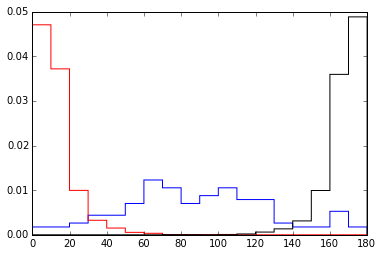

In [22]:
plt.hist(mptiltflat,histtype='step',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180])
plt.hist(uctiltflat,histtype='step',color='r',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180])
plt.hist(lctiltflat,histtype='step',color='k',normed='true',bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180])

In [23]:
ul_int=list([] for _ in xrange(8))
for k in range(8):
    ul_int[k]=ul_intneigh[traj.n_frames-8+k]
[np.mean(ul_int),np.std(ul_int)]

[0.15981573375261199, 0.013897431449497023]

In [24]:
mpc_int=list([] for _ in xrange(8))
for k in range(8):
    mpc_int[k]=chol_intneigh[traj.n_frames-8+k]
[np.mean(mpc_int),np.std(mpc_int)]

[2.9447054449682346, 0.76521254231016722]

In [25]:
#4 categories - R/Lo, R/Ld, AR, interfacial; this cell handles the bulk ones only


# for each midplane chol, calculate neighbor list of upper leaflet lipids to see how many are registered
# see if midplane chol tends to be near R or AR
mcutoffsq=1.0**2 #square of maximum xy distance for neighbors; 1 nm
mneigh=list([] for _ in xrange(traj.n_frames))
chol_loregneigh=list([] for _ in xrange(traj.n_frames))
chol_ldregneigh=list([] for _ in xrange(traj.n_frames))
chol_arneigh=list([] for _ in xrange(traj.n_frames))
mpc_regstate=list([] for _ in xrange(traj.n_frames))
mpc_lor=list([] for _ in xrange(traj.n_frames))
mpc_ldr=list([] for _ in xrange(traj.n_frames))
mpc_ar=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    mneigh[nn]=list([] for _ in xrange(len(allhead)))
    loregneighfraci=[]
    ldregneighfraci=[]
    arneighfraci=[]
    mpc_lor[nn]=0
    mpc_ldr[nn]=0
    mpc_ar[nn]=0
    for i in range(len(allhead)):
        loregneigh=0
        ldregneigh=0
        arneigh=0
        if ((resnames[allhead[i]]=='CHOL') and (head_leaflet[nn][i]==2) and (mpcint[nn][i]==0)):
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])):
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < mcutoffsq):
                    mneigh[nn][i].append(j) #upperhead index
                    if (loreg[nn][j]==1):
                        loregneigh+=1
                    elif (reg[nn][j]==1):
                        ldregneigh+=1
                    else:
                        arneigh+=1
            if len(mneigh[nn][i]):
                loregneighfraci.append(float(loregneigh)/len(mneigh[nn][i]))
                ldregneighfraci.append(float(ldregneigh)/len(mneigh[nn][i]))
                arneighfraci.append(float(arneigh)/len(mneigh[nn][i]))
                if (loregneighfraci[-1]>0.5):
                    mpc_lor[nn]+=1
                elif (ldregneighfraci[-1]>0.5):
                    mpc_ldr[nn]+=1
                elif (arneighfraci[-1]>0.5):
                    mpc_ar[nn]+=1



In [26]:
mpc_ar

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 0]

In [27]:
# mdw 2018-06-19 run lower lipids through like mpc to get denominators for mpc environment preference



# for each, calculate neighbor list of upper leaflet lipids to see how many are Lo/Ld/
# see if midplane chol tends to be near R or AR
lcutoffsq=1.0**2 #square of maximum xy distance for neighbors; 1 nm
uneigh=list([] for _ in xrange(traj.n_frames))
denom_int=list([] for _ in xrange(traj.n_frames))
denom_lor=list([] for _ in xrange(traj.n_frames))
denom_ldr=list([] for _ in xrange(traj.n_frames))
denom_ar=list([] for _ in xrange(traj.n_frames))
frac_denom_int=list([] for _ in xrange(traj.n_frames))
frac_denom_lor=list([] for _ in xrange(traj.n_frames))
frac_denom_ldr=list([] for _ in xrange(traj.n_frames))
frac_denom_ar=list([] for _ in xrange(traj.n_frames))


for nn in range(traj.n_frames):
    uneigh[nn]=list([] for _ in xrange(len(allhead)))
    denom_int[nn]=0
    denom_lor[nn]=0
    denom_ldr[nn]=0
    denom_ar[nn]=0
    
    lower_index=0
    for i in range(len(allhead)):
        intoppneigh=0
        intsameneigh=0
        loneigh=0
        ldneigh=0
        if (head_leaflet[nn][i]==0):
            xyi=allheadxy[nn][i]
            for j in range(len(upperheads[nn])):
                xyj=headxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < lcutoffsq):
                    uneigh[nn][i].append(j) #upperhead index
                    if (intmember[nn][j]):
                        intoppneigh+=1
                    elif (vphase3[nn][j]):
                        loneigh+=1
                    else:
                        ldneigh+=1
            for j in range(len(lowerheads[nn])):
                xyj=lheadxy[nn][j]
                distsq=(xyi[0]-xyj[0])**2 + (xyi[1]-xyj[1])**2
                if (distsq < lcutoffsq):
                    if (lintmember[nn][j]):
                        intsameneigh+=1
                    
            if len(uneigh[nn][i]):
                if (intoppneigh or intsameneigh):
                    denom_int[nn]+=1
                elif (loneigh>=ldneigh):
                    if (lvphase3[nn][lower_index]):
                        denom_lor[nn]+=1
                    else:
                        denom_ar[nn]+=1
                else:
                    if (lvphase3[nn][lower_index]):
                        denom_ar[nn]+=1
                    else:
                        denom_ldr[nn]+=1
            lower_index+=1

    denomsum=denom_int[nn]+denom_lor[nn]+denom_ldr[nn]+denom_ar[nn]
    frac_denom_int[nn]=float(denom_int[nn])/denomsum
    frac_denom_lor[nn]=float(denom_lor[nn])/denomsum
    frac_denom_ldr[nn]=float(denom_ldr[nn])/denomsum
    frac_denom_ar[nn]=float(denom_ar[nn])/denomsum
            
            
            


In [28]:
# normalize mpc by presence of each state in leaflet; looking for enrichment/depletion
int_frac=list([] for _ in xrange(traj.n_frames))
lor_frac=list([] for _ in xrange(traj.n_frames))
ldr_frac=list([] for _ in xrange(traj.n_frames))
ar_frac=list([] for _ in xrange(traj.n_frames))

for nn in range(traj.n_frames):
    if (frac_denom_int[nn]):
        int_frac[nn]=float(sum(mpcint[nn]))/frac_denom_int[nn]/num_mpc[nn]
    else:
        int_frac[nn]=0
    if (frac_denom_lor[nn]):
        lor_frac[nn]=float(mpc_lor[nn])/frac_denom_lor[nn]/num_mpc[nn]
    else:
        lor_frac[nn]=0
    if (frac_denom_ldr[nn]):
        ldr_frac[nn]=float(mpc_ldr[nn])/frac_denom_ldr[nn]/num_mpc[nn]
    else:
        ldr_frac[nn]=0
    if (frac_denom_ar[nn]):
        ar_frac[nn]=float(mpc_ar[nn])/frac_denom_ar[nn]/num_mpc[nn]
    else:
        ar_frac[nn]=0



In [29]:
data=frac_reg[-8:len(frac_reg)]
datb=mpcholfrac[-8:len(mpcholfrac)]
dat0=int_frac[-8:len(int_frac)]
dat1=lor_frac[-8:len(lor_frac)]
dat2=ldr_frac[-8:len(ldr_frac)]
dat3=ar_frac[-8:len(ar_frac)]

[np.mean(data),np.std(data),np.mean(datb),np.std(datb),np.mean(dat0),np.std(dat0),np.mean(dat1),np.std(dat1),np.mean(dat2),np.std(dat2),np.mean(dat3),np.std(dat3)]


[0.91946590909086912,
 0.0046153830232649263,
 0.014782157676348547,
 0.0039072923167322001,
 1.9024388547877529,
 0.45742107915202301,
 0.24662882050364598,
 0.13353303169732081,
 1.2616094724139093,
 0.36911107059448983,
 5.994791666666667,
 11.368172082269473]

In [30]:
#composition
ca=np.array(comp)
ca0=ca[-8:len(ca),0]
ca1=ca[-8:len(ca),1]
ca2=ca[-8:len(ca),2]
ca3=ca[-8:len(ca),3]
ca4=ca[-8:len(ca),4]
ca5=ca[-8:len(ca),5]




In [31]:
# fraction of each environment present 
d0=frac_denom_int[-8:len(frac_denom_int)]
d1=frac_denom_lor[-8:len(frac_denom_lor)]
d2=frac_denom_ldr[-8:len(frac_denom_ldr)]
d3=frac_denom_ar[-8:len(frac_denom_ar)]

#[np.mean(d0),np.std(d0),np.mean(d1),np.std(d1),np.mean(d2),np.std(d2),np.mean(d3),np.std(d3)]

In [32]:
chol_head_leaflet=list([] for _ in xrange(len(allhead))) #reverse of normal dimension order!
for i in range(len(allhead)):
#    chol_head_leaflet[i]=list([] for _ in xrange(traj.n_frames))
    for nn in (np.array(range(8))-8):
        if (head_leaflet[nn][i]!=2):
            chol_head_leaflet[i].append(head_leaflet[nn][i])

            
#see if any chol_head_leaflet has variation - i.e. if s.d. of leaflet is nonzero
num_flippers=0
chol_leaflet_sd=list([] for _ in xrange(len(allhead)))
for i in range(len(allhead)):
    chol_leaflet_sd[i]=np.std(chol_head_leaflet[i])
    if (chol_leaflet_sd[i]):
        num_flippers+=1 #number that flip, not number of flips
num_flippers

97

In [33]:
[np.mean(data),np.std(data),np.mean(datb),np.std(datb),np.mean(dat0),np.std(dat0),np.mean(dat1),np.std(dat1),np.mean(dat2),np.std(dat2),np.mean(dat3),np.std(dat3)]


[0.91946590909086912,
 0.0046153830232649263,
 0.014782157676348547,
 0.0039072923167322001,
 1.9024388547877529,
 0.45742107915202301,
 0.24662882050364598,
 0.13353303169732081,
 1.2616094724139093,
 0.36911107059448983,
 5.994791666666667,
 11.368172082269473]

In [34]:
[np.mean(ca0),np.std(ca0),np.mean(ca1),np.std(ca1),np.mean(ca2),np.std(ca2),np.mean(ca3),np.std(ca3),np.mean(ca4),np.std(ca4),np.mean(ca5),np.std(ca5),np.mean(d0),np.std(d0),np.mean(d1),np.std(d1),np.mean(d2),np.std(d2),np.mean(d3),np.std(d3),num_flippers]

[0.66520744665287557,
 0.0038365749051133906,
 0.085960221912187357,
 0.0042107388328303059,
 0.014533777689533844,
 0.0019753920657117241,
 0.85837805748777019,
 0.0054969732058607421,
 0.32025877565759064,
 0.002585203742366972,
 0.055661720600042416,
 0.0049299133883396124,
 0.24554602040473916,
 0.0095033205690968677,
 0.43150414030732975,
 0.0075165706748515524,
 0.31992650545777035,
 0.0050132238400676342,
 0.0030233338301607427,
 0.0017771776635612942,
 97]

In [36]:
from scipy.optimize import curve_fit
def func(x,a,b):
    return a*np.exp(-x/b)

In [37]:
all_tau=[]
for i in range(1):
    input=np.array(int_frac)
    input=input-np.mean(input)
    result=np.correlate(input,input,mode='full')
    result=result[result.size//2:]
    if (np.isfinite(result[0]/result[0])):
        result=result/result[0]
        popt,pcov=curve_fit(func,range(0,traj.n_frames,1),result[0:traj.n_frames])
        all_tau.append(popt[-1])

np.max(all_tau)

1.08867014736003

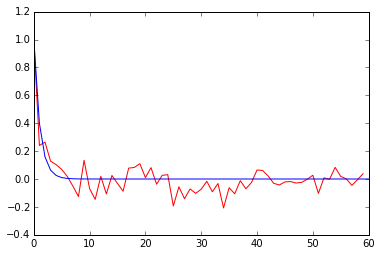

In [39]:
plt.plot(result,'r')
plt.plot(np.linspace(0,traj.n_frames,traj.n_frames+1), np.exp((-1./popt[-1])*np.linspace(0,traj.n_frames,traj.n_frames+1)))
plt.savefig('p20_autocorr.pdf',format='pdf')